# Question 1

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_sets/housing.csv')
data=data.dropna(how='any', axis=0)
print(list(data.columns.values),'\n')
print(data.info())
print(data.describe())

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB
None
          longitude      latitude  ...  median_income  median_house_value
cou

In [308]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
One_hot = cat_encoder.fit_transform(data[['ocean_proximity']])
print(One_hot.shape)


(20433, 5)


In [309]:
for i in range(One_hot.shape[1]):
  name='ocean_proximity_'+str(i)
  data[name]=One_hot[:, i]

data=data.drop(['ocean_proximity'], axis=1)

In [310]:
X=data.copy().drop(['median_house_value'], axis=1)
y=data['median_house_value']

from sklearn.model_selection import train_test_split

X_train_full, X_test_set = train_test_split(X, test_size=0.2, random_state=42)
y_train_full, y_test_set = train_test_split(y, test_size=0.2, random_state=42)

X_train_set, X_val_set= train_test_split(X_train_full, test_size=0.125, random_state=42)
y_train_set, y_val_set= train_test_split(y_train_full, test_size=0.125, random_state=42)

In [311]:
def mse( arr1, arr2):
  l= len(arr1)
  sum=0
  for i in range(l):
    sum+= (arr1[i]-arr2[i])**2
  sum=sum/l
  return pow(sum, 0.5)

In [312]:
def r2_score(y, y_pred):
  y=np.array(y)
  y_pred=np.array(y_pred)
  # print(len(y_pred)) #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
  mn=np.mean(y)
  
  var_mean=np.var(y-mn)
  var_line=np.var(y-y_pred)
  score= 1- (var_line/var_mean)
  return score

In [313]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=30)

tree_reg.fit(X_train_full, y_train_full)
y_pred= tree_reg.predict(X_test_set)

print('MSE ;',mse( y_pred, np.array(y_test_set)))
print('R2 score:', r2_score(y_test_set, y_pred)) 

MSE ; 68003.42259128639
R2 score: 0.6619605975452876


In [314]:
'''cross val from scratch'''

def cross(tree, X, y,folds ):
  x_chunks=np.array_split(X, folds)
  y_chunks=np.array_split(y, folds)
  val_scores=[]
  # print(len(y_chunks))
  for i in range(folds):
    X_test=x_chunks[i]
    y_test=y_chunks[i]

    x_train_splits=[]
    y_train_splits=[]

    for j in range(folds):
      if j!=i:
        x_train_splits.append(x_chunks[j])
        y_train_splits.append(y_chunks[j])

    X_train=pd.concat(x_train_splits)
    y_train=pd.concat(y_train_splits)    

    tree.fit(X_train, y_train)

    # X_test=np.array(X_test)
    y_test= list(y_test)

    y_pred=tree.predict(X_test)
    val_scores.append(r2_score(y_test, y_pred))

  return val_scores


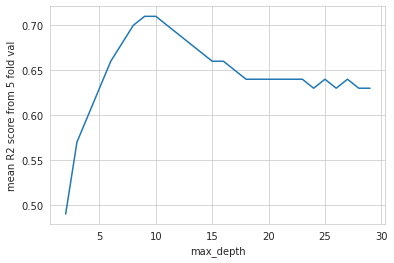

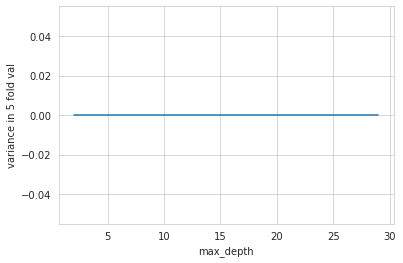

In [315]:
x=np.arange(2, 30)
mns=[]
vrs=[]
for i in range( 2, 30):
  tree_reg = DecisionTreeRegressor(max_depth=i)
  scores= cross(tree_reg, X_train_full, y_train_full, 5)
  mn= np.mean(np.array(scores))
  mn=round(mn, 2)
  vr= np.var(np.array(scores))
  vr=round(vr, 2)
  mns.append(mn)
  vrs.append(vr)

plt.plot(x, mns, label='mean R2 Score from validation sets')
plt.xlabel('max_depth')
plt.ylabel('mean R2 score from 5 fold val')
plt.show()

plt.plot(x, vrs, label='variancein R2 scores in validation scores')
plt.xlabel('max_depth')
plt.ylabel('variance in 5 fold val')
plt.show()

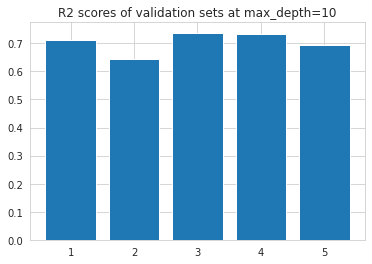

average R2 score across validation sets : 0.7


In [316]:
'''clearly best contender for max_depth is 10'''
tree_reg = DecisionTreeRegressor(max_depth=10)
scores= cross(tree_reg, X_train_full, y_train_full, 5)

mn= np.mean(np.array(scores))
mn=round(mn, 2)
vr= np.var(np.array(scores))
vr=round(vr, 2)

plt.bar(np.arange(1,6),scores)
plt.title('R2 scores of validation sets at max_depth=10')
plt.show()

print('average R2 score across validation sets :', mn)

In [317]:
from random import randrange as sallu

def bag(X, y, count, ratio=0.5):
  l_= len(y)
  sample_len=l_*ratio

  bags=[]
  for i in range(count):
    cur_sample_len=0
    cur_X= pd.DataFrame(columns= X.columns.values )
    cur_y= []

    while cur_sample_len< sample_len:
      index=sallu(l_)
      cur_X= cur_X.append(X.iloc[index], ignore_index=True)
      cur_y.append(y.iloc[index])
      cur_sample_len+=1

    cur_y= pd.DataFrame(cur_y)
    bags.append([cur_X, cur_y])
  return bags



bags=bag( X_train_full, y_train_full, 10)

In [318]:
r2s=[]

model= DecisionTreeRegressor()
for data in bags:
  model.fit(data[0], data[1])
  pred=model.predict(X_test_set)
  score= r2_score( y_test_set, pred)
  r2s.append(score)

R2 scores of 10 bags : [0.5839472343941019, 0.5654338518481571, 0.5883982452584746, 0.6256978154354967, 0.5854928935939464, 0.5999561520234633, 0.575330345406841, 0.6017149634597535, 0.6321625926078837, 0.5763519105968178]
Average R2 score : 0.5934486004624937


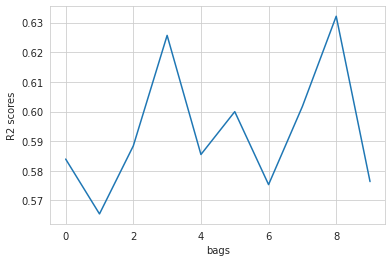

In [319]:
print('R2 scores of 10 bags :', r2s)
print('Average R2 score :', np.mean(np.array(r2s)))
plt.plot(np.arange(10), r2s)
plt.xlabel('bags')
plt.ylabel('R2 scores')
plt.show()


In [320]:
'''next we attempt to combine the trees'''

def combine(depth=30):
  l__=len(bags[0][1])//2 +1
  y_pred=[0.0]*l__
  y_pred=np.array(y_pred)

  model= DecisionTreeRegressor(max_depth=depth)
  for data in bags:
    model.fit(data[0],data[1] )
    pred=np.array( model.predict(X_test_set))
    y_pred+= pred
  
  y_pred=y_pred/10
  return r2_score(y_test_set, y_pred)

r2_=combine()
print(' R2 score of combined tree is: ', r2_)

 R2 score of combined tree is:  0.7909896494573022


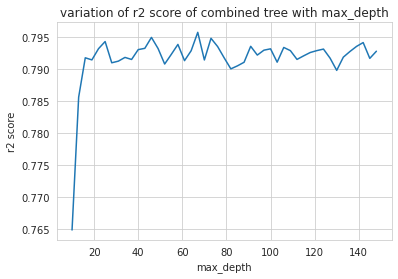

In [321]:
x=np.arange(10, 150, 3)
y=[]
for i in range(10, 150, 3):
  y.append(combine(i))
  
plt.plot(x, y)
plt.xlabel('max_depth')
plt.ylabel('r2 score')
plt.title('variation of r2 score of combined tree with max_depth')
plt.show()

In [322]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

regr= RandomForestRegressor()
regr.fit(X_train_full, y_train_full)

prediction= regr.predict(X_test_set)
print('MSE from  RandomForestRegressor :', mean_squared_error(prediction, y_test_set))
print('MAE from  RandomForestRegressor :', mean_absolute_error(prediction, y_test_set))
print('R2 from  RandomForestRegressor :', r2_score( y_test_set, prediction))


MSE from  RandomForestRegressor : 2378793385.9848604
MAE from  RandomForestRegressor : 31662.971475409835
R2 from  RandomForestRegressor : 0.8260503152973535


In [323]:
from sklearn.ensemble import AdaBoostRegressor

Aregr= AdaBoostRegressor()
Aregr.fit(X_train_full, y_train_full)

prediction= Aregr.predict(X_test_set)
print('MSE from  AdaBoostRegressor :', mean_squared_error(prediction, y_test_set))
print('MAE from  AdaBoostRegressor :', mean_absolute_error(prediction, y_test_set))
print('R2 from  AdaBoostRegressor :', r2_score( y_test_set, prediction))

MSE from  AdaBoostRegressor : 7183886626.873426
MAE from  AdaBoostRegressor : 70654.03172313848
R2 from  AdaBoostRegressor : 0.4746770269975248


# Question 2


In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_sets/Breast_cancer_data.csv')
data=data.dropna(how='any', axis=0)
print(data.head(),'\n')
print(list(data.columns.values),'\n')
print(data.info())

   mean_radius  mean_texture  ...  mean_smoothness  diagnosis
0        17.99         10.38  ...          0.11840          0
1        20.57         17.77  ...          0.08474          0
2        19.69         21.25  ...          0.10960          0
3        11.42         20.38  ...          0.14250          0
4        20.29         14.34  ...          0.10030          0

[5 rows x 6 columns] 

['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness', 'diagnosis'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory

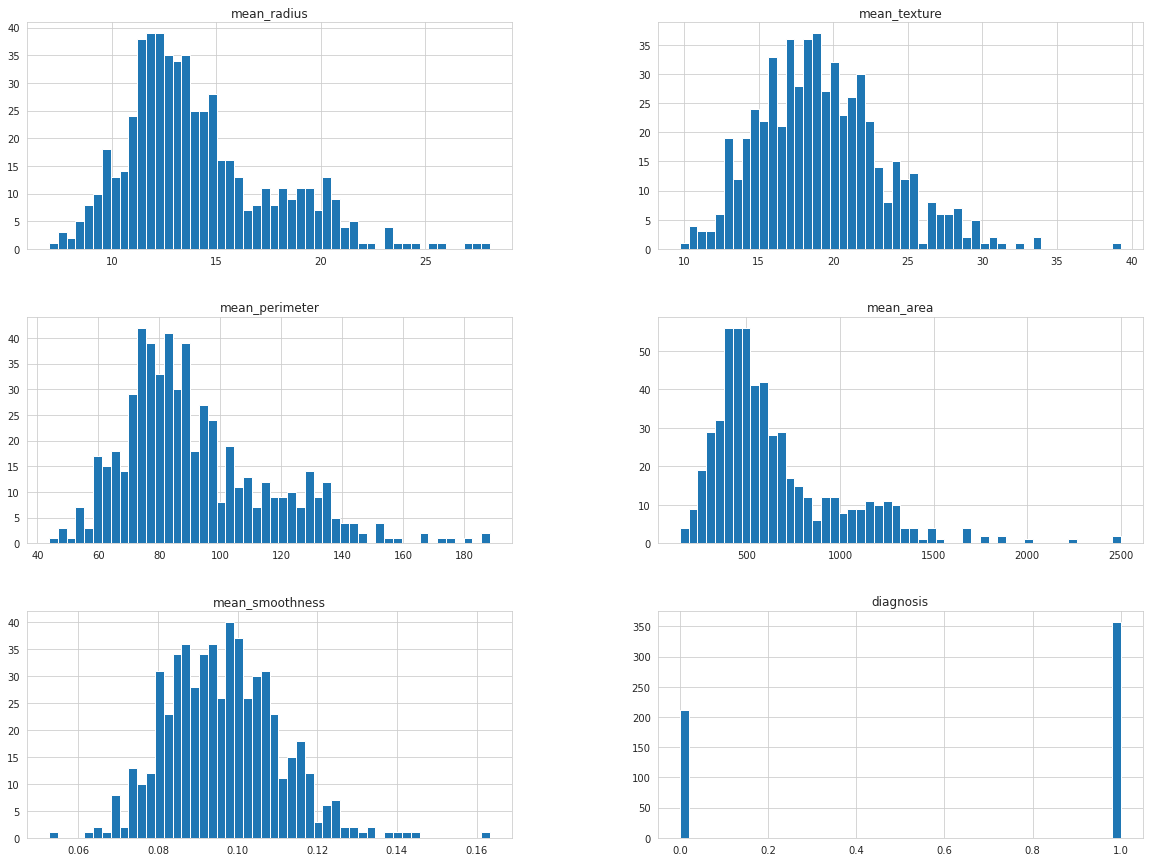

In [325]:
'''this is a fairly small dataset with no missing values'''
'''as the classifier being used is decision tree, no need for scaling and
 therefore no data-preprocesssing steps needed'''

data.hist(bins=50, figsize=(20,15))
plt.show()

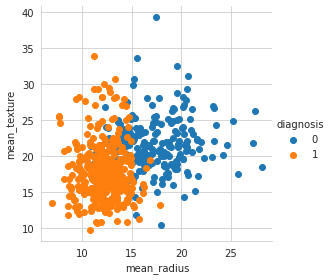

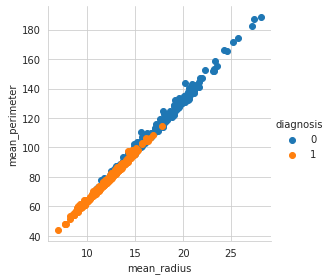

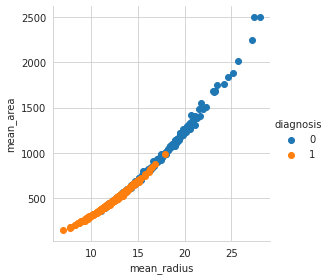

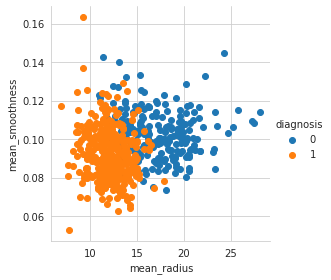

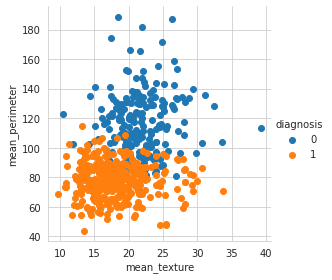

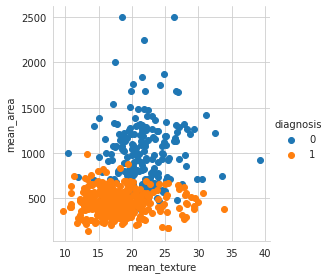

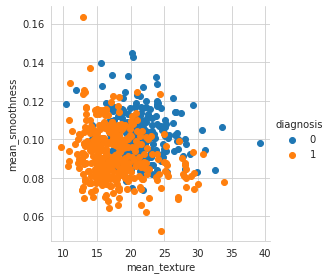

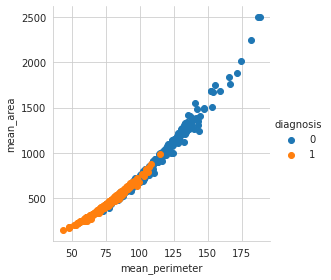

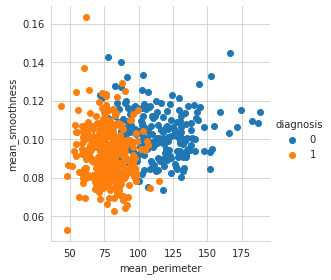

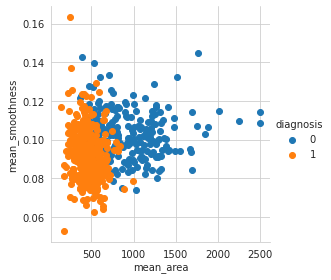

In [326]:
import seaborn as sns
sns.set_style("whitegrid") 
features= list(data.columns.values)

for i in range(5):
  for j in range(i+1, 5):
    sns.FacetGrid(data, hue ="diagnosis", 
              height = 4).map(plt.scatter,
                              features[i], features[j]).add_legend()

In [327]:
'''from the looks of it, there doesnt seem to exist a low dimensional decision boundary'''
X=data.copy().drop('diagnosis', axis=1)
y=data['diagnosis'].copy()

from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test= train_test_split( X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val= train_test_split( X_train_full, y_train_full, test_size= 0.125, random_state=42)

In [328]:
def gini_index(data):
  classes= np.unique(data)
  gini=1

  for c_i in classes:
    p= len( data[data==c_i])/len(data)
    gini-=p**2
  return gini

def con_to_cat(data):
  sample_count=data.shape[0]
  feature_count=data.shape[1]

  max_gini=-999999999999
  split={}

  for feature in range(feature_count):
    values=data[:, feature]
    values=np.unique(values)
    for threshold in values:
      data_left=np.array( [row for row in data if row[feature]<= threshold])
      data_right=np.array( [row for row in data if row[feature]> threshold])

      if( len(data_left)>0 and len(data_right)>0):
        y, left_y, right_y= data[:,-1], data_left[:, -1], data_right[:, -1]

        wl=len(left_y)/len(y)
        wr=len(right_y)/len(y)
        gini= gini_index(y)- wl*gini_index(left_y) - wr*gini_index(right_y)
        if gini> max_gini and feature!=5: ######second condition added idky<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
          max_gini= gini
          split['gini']=max_gini
          split['threshold']= threshold
          split['left']= data_left
          split['right']=data_right
          split['feature']=feature
          #print(feature)
  
  return split

In [329]:
'''
con_to_cat() automatically selects the attribute which leads to the best split and performs the split
therefore 4 a. b. done'''

class Node():
  def __init__(self, gini=None , threshold=None , left=None , right=None, feature=None ,value=None):
    self.gini=gini
    self.threshold=threshold
    self.left=left
    self.right=right
    self.feature=feature
    self.value=value



class DTC():
  def __init__(self, min_samples_split=2, max_depth=2):
    self.min_samples_split= min_samples_split
    self.max_depth=max_depth
    self.root= None

  ''' referrenced from https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb'''
  def tree(self,data , curr_depth=0):
    X, y= data[:, :-1], data[:, -1]

    sample_count, feature_count= X.shape
    if curr_depth<=self.max_depth :
      if  sample_count> self.min_samples_split:
        split= con_to_cat(data)
        if split['gini']>0:
          left_tree= self.tree( split['left'], curr_depth+1)
          right_tree= self.tree( split['right'], curr_depth+1)
          return Node( split['gini'], split['threshold'], left_tree, right_tree, split['feature'])

    #pred_value = Counter(y)

    count=0
    y_=list(y)
    pred_value= y_[0]
    for i in y_:
      curr_freq= y_.count(i)
      if curr_freq>count:
        count=curr_freq
        pred_value=i
    #return Node( value= pred_value.most_common(1)[0][0])
    return Node( value= pred_value) #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

  def fit(self, X, y):
    data= np.concatenate( (X,y[:, None]), axis=1)
    self.root= self.tree(data)

  def predict(self, X):
    predictions=[]
    for i in X:
      pred= self.make_prediction(i, self.root)
      predictions.append(pred)
    return predictions


  def make_prediction(self, x, tree):
    if tree.value!=None:
     return tree.value
    
    feature = x[tree.feature] 
    if feature < tree.threshold:
      return self.make_prediction(x, tree.left)
    else:
      return self.make_prediction(x, tree.right)

In [330]:
dtc= DTC(min_samples_split=2, max_depth=7)
dtc.fit( X_train_full, y_train_full)

y_pred= dtc.predict(np.array(X_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [331]:
def accuracy( arr1, arr2):
  l= len(arr1)
  sum=0
  for i in range(l):
    if arr1[i]==arr2[i]:
      sum+=1
  return sum/l

In [332]:
print(' accuracy on our simple decision tree is :', accuracy( list(y_test), y_pred))

 accuracy on our simple decision tree is : 0.9035087719298246


In [336]:
'''cross val from scratch'''

def cross(tree, X, y,folds ):
  x_chunks=np.array_split(X, folds)
  y_chunks=np.array_split(y, folds)
  val_scores=[]
  # print(len(y_chunks))
  for i in range(folds):
    X_test=x_chunks[i]
    y_test=y_chunks[i]

    x_train_splits=[]
    y_train_splits=[]

    for j in range(folds):
      if j!=i:
        x_train_splits.append(x_chunks[j])
        y_train_splits.append(y_chunks[j])

    X_train=pd.concat(x_train_splits)
    y_train=pd.concat(y_train_splits)    

    tree.fit(X_train, y_train)

    X_test=np.array(X_test)
    y_test= list(y_test)

    y_pred=tree.predict(X_test)
    val_scores.append(accuracy(y_pred, y_test))

  return val_scores


In [338]:
x=np.arange(2,19)
y=[]
for i in range(2, 19):
  tree= DTC(max_depth= i)
  val_score= np.array(cross(tree, X_train_full, y_train_full, 5))
  y.append( np.mean(val_score))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


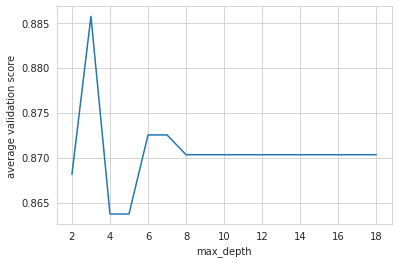

In [339]:
plt.plot(x, y)
plt.ylabel('average validation score')
plt.xlabel('max_depth')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


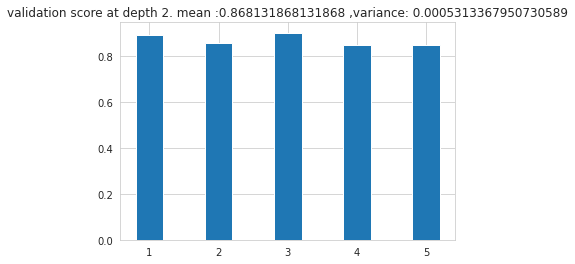

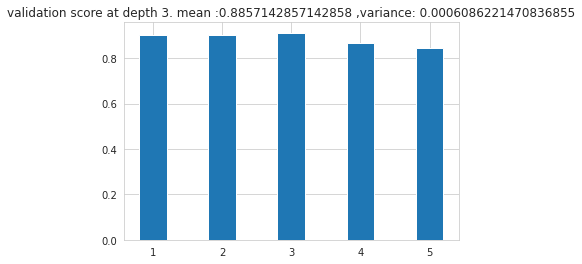

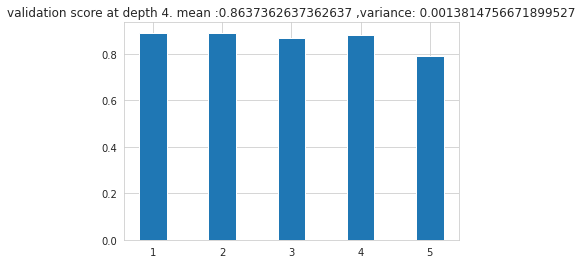

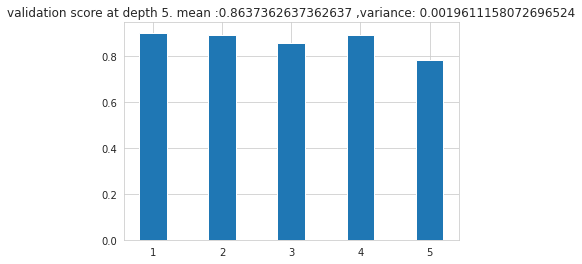

In [340]:

score_index=list(np.arange(1,6))
# plt.bar(score_index, val_score,  width=0.4)
# print(val_score)

for i in range(2, 6):
  tree= DTC(max_depth= i)
  val_score= np.array(cross(tree, X_train_full, y_train_full, 5))
  plt.bar(score_index, val_score,  width=0.4)
  mean=np.mean(np.array(val_score))
  variance= np.var(np.array(val_score))
  plt.title('validation score at depth '+ str(i)+ '. mean :'+ str(mean)+' ,variance: '+ str(variance))
  plt.show()



In [341]:
'''with depth=3, we get maximum average validation scores with minimum variance'''
!pip install xgboost

In [342]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(subsample=0.7, max_depth=4)
xg_reg.fit(X_train,y_train)

XGBClassifier(max_depth=4, subsample=0.7)

In [343]:
y_pred_train=xg_reg.predict(X_train)
y_pred_test=xg_reg.predict(X_test)

print('accuracy of training data: ',accuracy(list(y_train), y_pred_train))
print('accuracy of testing data: ', accuracy(list(y_test), y_pred_test))

accuracy of training data:  0.9874371859296482
accuracy of testing data:  0.9385964912280702


In [344]:
!pip install lightgbm

In [345]:
import lightgbm as lgb
from sklearn import metrics

for i in range(10,30,5):
  model = lgb.LGBMClassifier(num_leaves=i,max_depth=3,random_state=42)
  model.fit(X_train, y_train)
  print('model performance at depth 4 and num of leaves :', i)
  print(metrics.classification_report(y_test,model.predict(X_test)))
  print('\n')

model performance at depth 4 and num of leaves : 10
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



model performance at depth 4 and num of leaves : 15
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



model performance at depth 4 and num of leaves : 20
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy          

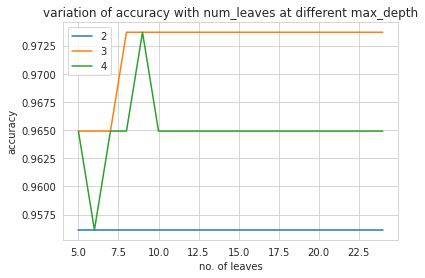

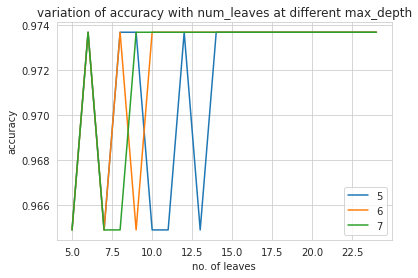

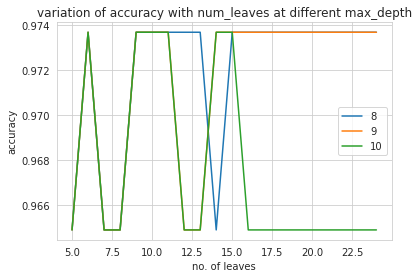

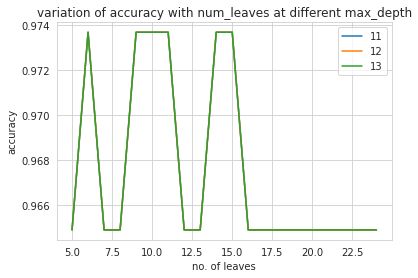

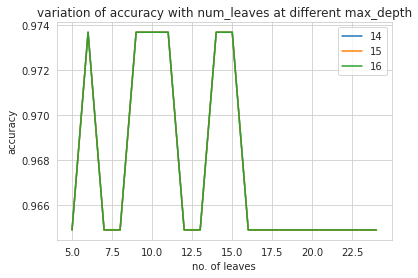

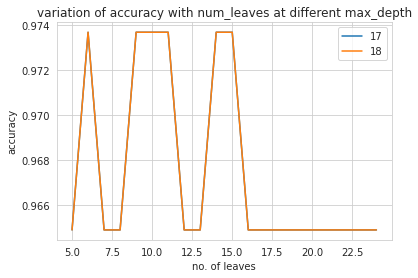

In [346]:
depths= np.arange(2,19)
leaves= np.arange(5,25)

for depth in depths:
  acc=[]
  for leaf in leaves:
    model = lgb.LGBMClassifier(num_leaves=leaf ,max_depth=depth ,random_state=42)
    model.fit(X_train, y_train)
    acc.append(accuracy(list(y_test),model.predict(X_test)))
  name=str(depth)
  plt.plot(leaves, acc, label=name)
  plt.legend()
  plt.xlabel('no. of leaves')
  plt.ylabel('accuracy')
  plt.title('variation of accuracy with num_leaves at different max_depth')
  if (depth-1)%3==0:
    plt.show()
